# Stitching thermal drone imagery

In [236]:
# Variable definition
imgDir = 'data/lsm/Flight 1 - Library/'
pathFile = 'data/lsm/Flight 1.csv'
utcDiff = -1
pathColumns = ['timestamp','latitude','longitude','altitude(m)','temperature(F)']
minAlt, maxAlt, altCol = 119.7, 120.3, 'altitude(m)'
utmZone, hemisphere = '31n', 'north'
pxSize = 0.27 # pixel size (m) - for now
resolution = 0.5

In [231]:
# Import packages
#%pip install opencv-python
import glob
import rasterio as ro
import re
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Proj
from tqdm import tqdm
from scipy.interpolate import griddata
from PIL import Image
#import cv2 as cv

In [162]:
## Retrieve images and path information
imgs = [_ for _ in glob.glob(imgDir+'*.*') if _.endswith(('.jpg','.png','.tif'))]
imgs.sort()
pathDf = pd.read_csv(pathFile)

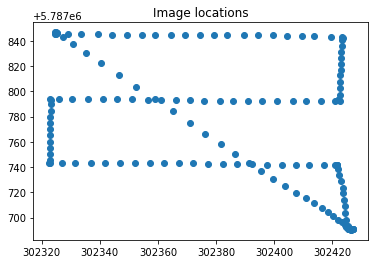

In [216]:
## Get corresponding GPS info matched with images
# Extract date and time from filenames
imgdates = [re.search('/20(.+?)_', path).group(1) for path in imgs] # Extract date from filename
imgtimes = [re.search('_(.+?)_', path).group(1) for path in imgs] # Extract time from filename
# Convert to unix datetime 
imgdatetimes = np.array([(datetime.timestamp(datetime(int('20'+dates[i][:2]),int(dates[i][2:4]),int(dates[i][4:6]),int(times[i][:2])+utcDiff,int(times[i][2:4]),int(times[i][4:6])))) for i in range(len(imgs))])*1000
# Get nearest GPS timestamp
gpstimes = [min(path['timestamp'], key=(lambda list_value : abs(list_value - i))) for i in imgdatetimes]
# Create image dataframe
imgDf = pd.DataFrame(data=np.array([imgs,gpstimes]).transpose(),columns=['imgPath','timestamp'])
imgDf['timestamp'] = imgDf['timestamp'].astype(float)

# Merge with path dataframe
merged = imgDf.merge(pathDf[pathColumns], on='timestamp', how='left')
# Filter for acceptable measurement altitudes
merged = merged.loc[(merged[altCol] > minAlt) & (merged[altCol] < maxAlt)]

# Convert coordinates to UTM
myProj = Proj('+proj=utm +zone='+utmZone+', +'+hemisphere+' +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
merged['x'], merged['y'] = myProj(merged['longitude'].values, merged['latitude'].values)

# Plot route
plt.scatter(merged.x,merged.y)
plt.title('Image coordinates')
plt.show()

In [314]:
## Get point grid with GPS info
imgEx = ro.open(imgs[0])
imgSize = imgEx.read().shape
xCoords, yCoords = [(np.array(range(imgSize[i]))-(imgSize[i]/2))*pxSize+pxSize/2 for i in [1,2]]
xmCoords, ymCoords = np.meshgrid(xCoords,yCoords)
xmcr, ymcr = xmCoords.reshape(-1,1), ymCoords.reshape(-1,1)

total = [0,0,0,0,0]

print('Number of images to process: '+str(len(merged)))
for index, row in tqdm(merged.iterrows()):
    img = ro.open(row.imgPath)
    total = np.vstack((total, np.concatenate((xmcr+row.x, ymcr+row.y,img.read().reshape(-1,3)),axis=-1)))
allDf = pd.DataFrame(total[1:],columns=['x','y','r','g','b']) 

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:216: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
4it [00:00, 33.41it/s]

Number of images to process: 155


155it [01:02,  2.49it/s]


In [320]:
# Convert to grid for image
res=0.5
extent = (np.ceil(min(allDf.x)), np.floor(max(allDf.x)),np.ceil(min(allDf.y)),np.floor(max(allDf.y)))
xsGrid = np.arange(extent[0], extent[1], resolution)
ysGrid = np.arange(extent[2], extent[3], resolution)
xsGridm, ysGridm = np.meshgrid(xsGrid, ysGrid)

In [371]:
# Associate values with grid points by interpolation - Too slow, probs need something better than this
r,g,b = [griddata(total[1:,:2], total[1:,i], (xsGridm, ysGridm), method='linear') for i in [2,3,4]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


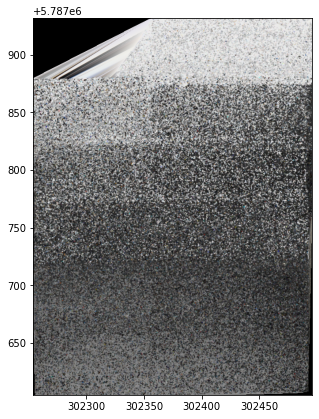

In [396]:
# Plot 
fig, ax = plt.subplots(1,1,figsize=[5,8])
a = ax.imshow(np.dstack((r, g, b)).astype(int),extent=extent)

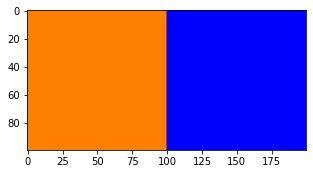

In [393]:
# Demo it works
array = np.zeros([100, 200, 3], dtype=np.uint8)
array[:,:100] = [255, 128, 0] #Orange left side
array[:,100:] = [0, 0, 255]   #Blue right side

img = Image.fromarray(array)
fig, ax = plt.subplots(1,1,figsize=[5,8])
a = ax.imshow(array.astype(np.uint8))

## OpenCV stitching

In [5]:
img = cv.imread(imgs[0])
cv.imshow("Display",img)